In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from fastai.tabular import *
import scipy.signal as s

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
path.ls()

[WindowsPath('data/LFP_Prediction/.ipynb_checkpoints'),
 WindowsPath('data/LFP_Prediction/ims'),
 WindowsPath('data/LFP_Prediction/lfp_labels.csv'),
 WindowsPath('data/LFP_Prediction/lfp_labels_new.csv'),
 WindowsPath('data/LFP_Prediction/lfp_labels_new_data.csv'),
 WindowsPath('data/LFP_Prediction/model_fr_lfp.csv'),
 WindowsPath('data/LFP_Prediction/model_fr_lfp_new.csv'),
 WindowsPath('data/LFP_Prediction/model_LFP_and_FR.csv')]

In [5]:
labels = pd.read_csv(path/"lfp_labels_new_data.csv", index_col = "start")

In [6]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")

In [7]:
df = df.iloc[:len(labels)]

In [8]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)

In [9]:
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)

In [10]:
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [11]:
df.head()

,PNA1,PNA2,PNA3,PNA4,PNA5,PNC1,PNC2,PNC3,PNC4,PNC5,...,ITN2,ITN3,ITN4,ITN5,rawLFP,filtLFP,hilbLFP,avgPNA,avgPNC,avgITN
0,0.0,0.00000,0.2739,0.79453,0.45424,0.0,0.0000,0.00000,0.79777,0.59773,...,16.129,18.165,19.241,22.929,-0.858470,0.55633,0.62672,0.304534,0.279100,27.2928
1,0.0,1.45240,0.5478,0.79453,0.68135,0.0,0.0000,0.00000,0.39888,0.59773,...,18.433,15.441,16.121,14.053,-1.146800,0.68830,0.73526,0.695216,0.199322,12.8096
2,0.0,0.72622,0.2739,0.00000,0.68135,0.0,0.0000,0.71023,1.19660,0.00000,...,20.737,21.798,17.681,13.314,0.483210,0.69304,0.85662,0.336294,0.381366,14.7060
3,0.0,0.72622,0.2739,0.79453,0.22712,0.0,1.8416,0.71023,0.39888,0.59773,...,13.825,13.624,24.441,13.314,1.875100,0.55921,0.90646,0.404354,0.709688,13.0408
4,0.0,1.45240,0.5478,0.15891,1.36270,0.0,0.0000,2.13070,0.79777,1.19550,...,16.129,23.615,14.041,16.272,0.093743,0.30411,0.94929,0.704362,0.824794,14.0114


In [12]:
labels.head()

,P_or_T_above,next_above,time_until_peak,time_until_trough,peaks_above,troughs_above,next_peak,next_trough
start,,,,,,,,
0,False,0,2,9,0,0,0.85662,0.83115
1,False,0,1,8,0,0,0.85662,0.83115
2,False,0,13,7,0,0,0.89606,0.83115
3,False,0,12,6,0,0,0.89606,0.83115
4,False,0,11,5,0,0,0.89606,0.83115


In [13]:
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [14]:
class TimeWindowList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, num_forward, data_input, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_forward = num_forward
        self.num_back = num_back
        self.data_input = data_input
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        self.copy_new.append("num_forward")
        
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :-1])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        #return torch.Tensor(int(1 in self.its[i + self.num_back: i + self.num_back + self.num_forward, 3]))[None]
        return int(self.data_input[self.items[i], -1] >= 2)

In [15]:
num_back = 40
num_forward = 10

In [16]:
columns = df.columns

In [17]:
columns

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

In [18]:
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)] + [labels.next_peak], axis = -1)

In [19]:
data_input.shape

(199300, 20)

Limits the training data to where the peak is less than 4 ms ahead

In [20]:
indexes = [i for i in range(num_back, len(data_input)) if labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 0]

In [21]:
len(indexes)

39558

In [22]:
#Replicating each true sample once
index = 0
while(index < len(indexes)):
    if data_input[indexes[index]][-1] >= 2:
        indexes = np.insert(indexes, index, indexes[index], axis = 0)
        index += 1
    index += 1

In [23]:
len(indexes)

44829

In [34]:
data = (TimeWindowList(indexes, num_back, num_forward, data_input)
                .split_by_idx(range(10000))
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))

In [25]:
data

DataBunch;

Train: LabelList (34829 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (10000 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,1,1
Path: .;

Test: None

In [26]:
class PaperModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (8, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (6, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
            nn.Conv1d(1, 1, kernel_size = (5, num_features), padding = (2, 9)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        self.lins = nn.Sequential(
            nn.Linear(num_features * 40, 25),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.Linear(25, out_size),
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [27]:
def isNan(num):
    return num != num

In [28]:
def true_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [29]:
def false_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [35]:
learn = Learner(data, PaperModel(2, 19), loss_func = torch.nn.modules.loss.CrossEntropyLoss(weight = torch.Tensor([1, 2]).cuda()), 
            metrics = [accuracy, true_acc, false_acc], wd = 1e-4)

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.63E-02


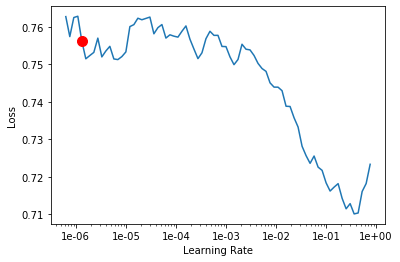

In [37]:
learn.recorder.plot(skip_end = 10, suggestion=True)

In [38]:
lr = 1e-2

In [39]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,time
0,0.502794,0.481738,0.763800,0.612344,0.778714,00:28
1,0.496156,0.531732,0.691200,0.765415,0.634573,00:28
2,0.483770,0.515844,0.825000,0.291808,0.969402,00:28
3,0.472680,0.447810,0.822700,0.455172,0.905749,00:28
4,0.467326,0.440444,0.788000,0.640243,0.800216,00:27
5,0.450354,0.453806,0.824500,0.488576,0.899452,00:28
6,0.445565,0.437149,0.809400,0.585916,0.846377,00:27
7,0.448365,0.437610,0.815100,0.559510,0.864663,00:28
8,0.447362,0.437134,0.818200,0.554209,0.872785,00:28
9,0.434940,0.434845,0.808900,0.585094,0.845961,00:28


## Results

In [40]:
interp = ClassificationInterpretation.from_learner(learn, ds_type = DatasetType.Valid)

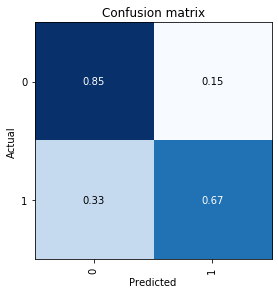

In [41]:
interp.plot_confusion_matrix(normalize = True)

In [42]:
confusion = interp.confusion_matrix()

In [43]:
#Above accuracy
confusion[1][1] / confusion[1].sum()

0.6735042735042736

In [44]:
#Not above accuracy
confusion[0][0] / confusion[0].sum()

0.8502610966057441

## Explainability

In [45]:
from fastai.callbacks.hooks import *

In [46]:
m = learn.model.eval()

In [47]:
m

PaperModel(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(8, 1), stride=(1, 1), padding=(3, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25)
    (4): Conv2d(64, 128, kernel_size=(6, 1), stride=(1, 1), padding=(3, 0))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
    (8): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4)
    (12): Conv1d(1, 1, kernel_size=(5, 19), stride=(1,), padding=(2, 9))
    (13): ReLU()
    (14): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.4)
  )
  (lins): Sequential(
    (0): Linear(in_features=760, out_features=25, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=T

In [70]:
relu = nn.ReLU()

In [59]:
#runs the bigen xb through the model and hooks the activations and the gradients.
def hooked_backward(cat, xb, layer):
    with hook_output(m.convs[layer]) as hook_a: 
        with hook_output(m.convs[layer], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [60]:
#Returns the grad_cam at the given layer on the given item (x value)
def get_grad_cam(data, item, layer, m, y_actual = True):
    y = item[1]
    if not y_actual:
        y = get_pred(item)
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(y, xb, layer)
    acts = hook_a.stored[0].cpu()
    
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    
    return  np.transpose((acts*grad_chan[...,None,None]).mean(0))

In [111]:
#Makes each row in the array percents of the row sum.
def percentize(features):
    for i in range(len(features)):
        features[i] = np.array([features[i][j] / features[i].max() for j in range(len(features[i]))])
        
    return features

In [62]:
#Returns the models prediction on the given item.
def get_pred(item):
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    return int(np.argmax(m(xb)[0]))

In [63]:
#Draws the given x with the given heat map over it.
def draw_map(x, heat_map, save = None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.plot(x)

    # Get second axis
    ax2 = ax.twinx()
    plt.imshow(np.repeat(heat_map[None], 100, 0), alpha = 0.6, interpolation='bilinear')
    plt.colorbar()
    plt.show()
    if save != None:
        fig.savefig(path/"ims"/save)

In [64]:
#Plots the average x from the items and grad cam results from the gs.
def plot_avg_var_map(var, items, gs, targ, save = None):
    total = []
    for piece in items:
        if int(piece[1]) == targ:
            total.append(np.array(piece[0].data[0][:,var]))
    total = np.array(total)
    x = total.mean(0)
    draw_map(x, gs.mean(0)[var], save = save)

In [65]:
def draw_variable(item, g, var):
    x = item[0].data[0][:, var]
    draw_map(x, g[var])

In [66]:
#Gets the grad_cams for each piece of the data's validation set.
#Split into grad cams for above and not above data.
def get_grad_cams(data):
    f_res = []
    t_res = []
    for item in data.valid_ds:
        g = get_grad_cam(data, item, 5, m, y_actual = False)
        g = relu(g)
        if get_pred(item) == 0:
            f_res.append(np.array(g))
        else:
            t_res.append(np.array(g))
    return np.array(f_res), np.array(t_res)

In [67]:
#Returns variable importance for predicting false and predicting true.
def get_var_import(f_gs, t_gs):
    fs = []
    ts = []
    for g in f_gs:
        fs.append(list(g.mean(1)))
    for g in t_gs:
        ts.append(list(g.mean(1)))
    return np.array(fs).mean(0), np.array(ts).mean(0)

In [71]:
var_names = list(columns[:16]) + list(columns[-3:])

In [72]:
%%time
f_gs, t_gs = get_grad_cams(data)

Wall time: 2min 23s


In [74]:
f_gs.mean(0).shape

(19, 40)

In [75]:
f_imp, t_imp = get_var_import(f_gs, t_gs)

In [81]:
f_imp = (f_imp / f_imp.sum()) * 100

In [82]:
t_imp = (t_imp / t_imp.sum()) * 100

PNA1
Importance: 2.7935033%


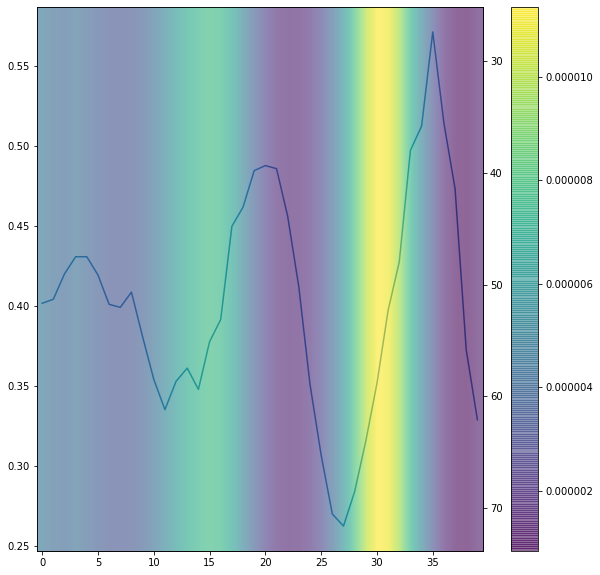

PNA2
Importance: 3.2346737%


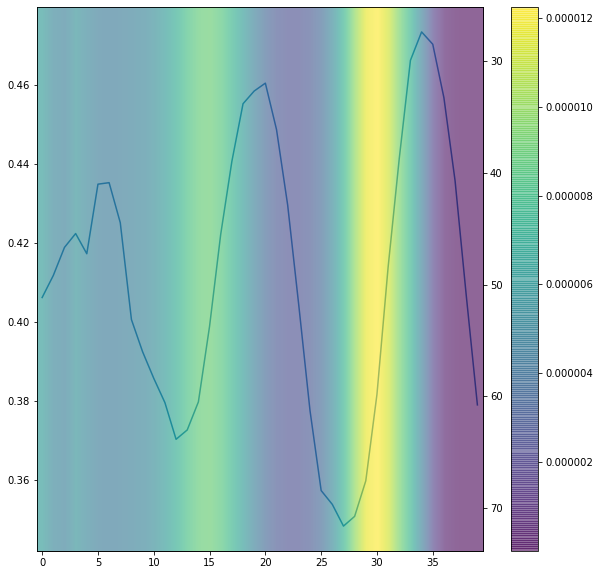

PNA3
Importance: 2.5270007%


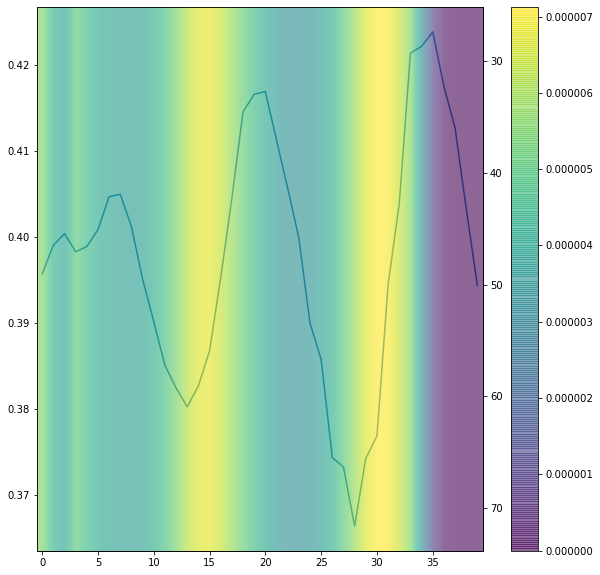

PNA4
Importance: 3.3270762%


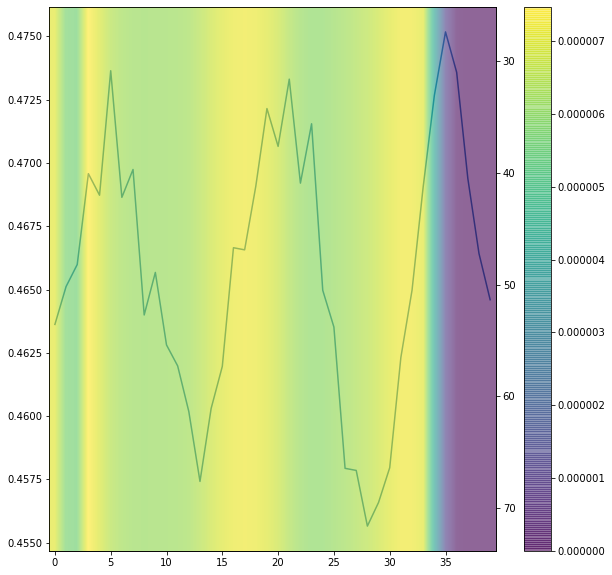

PNA5
Importance: 5.053693%


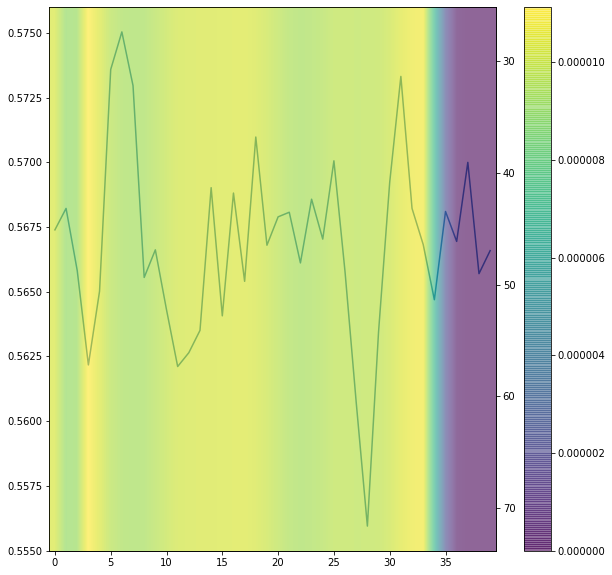

PNC1
Importance: 1.669604%


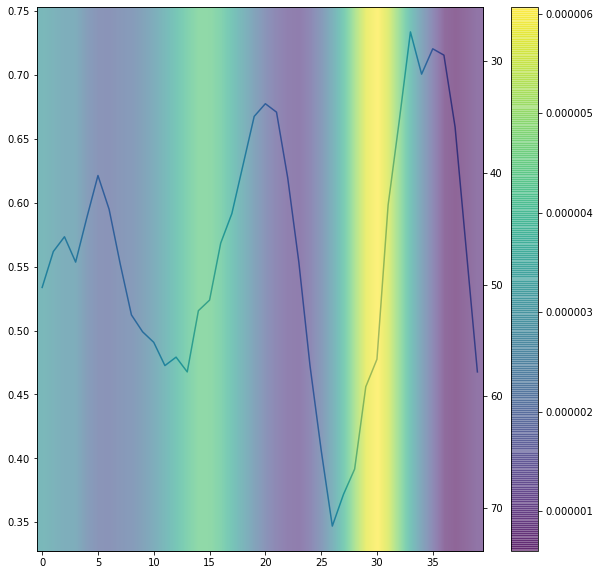

PNC2
Importance: 4.494135%


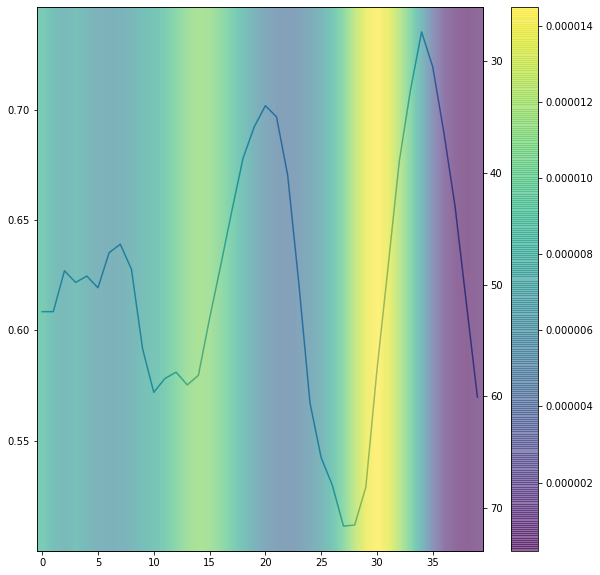

PNC3
Importance: 4.981009%


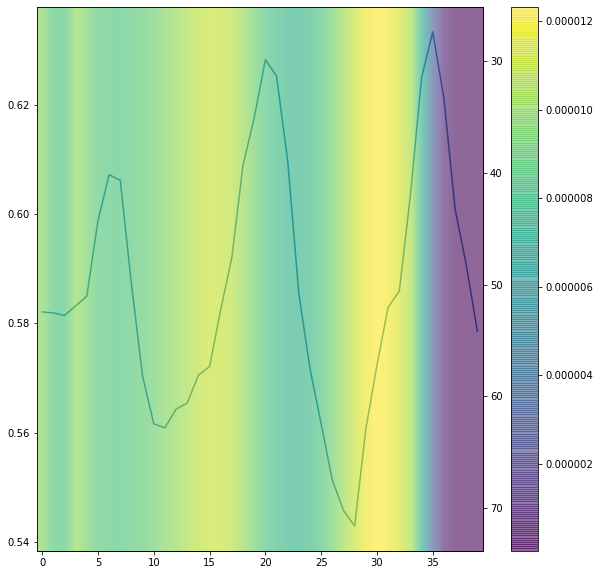

PNC4
Importance: 7.111523%


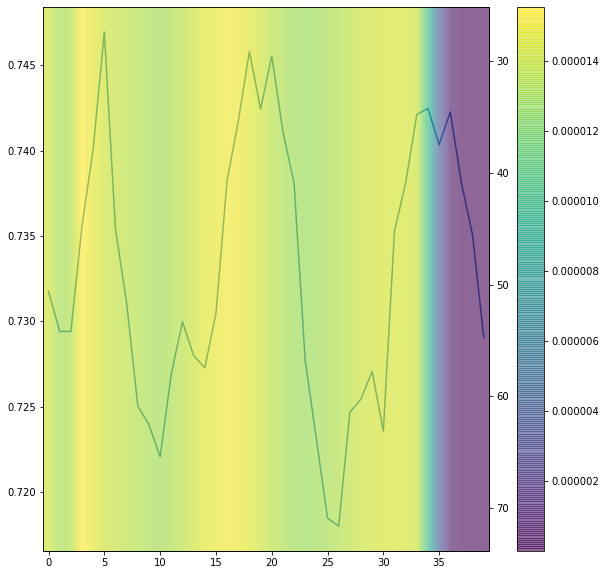

PNC5
Importance: 8.429467%


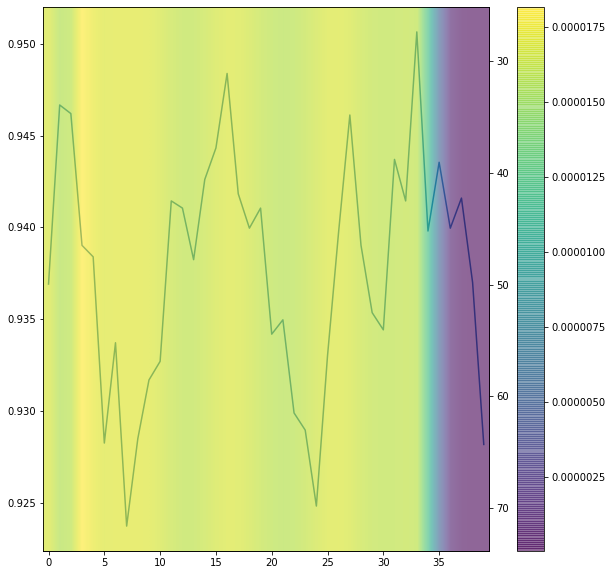

ITN1
Importance: 13.066837%


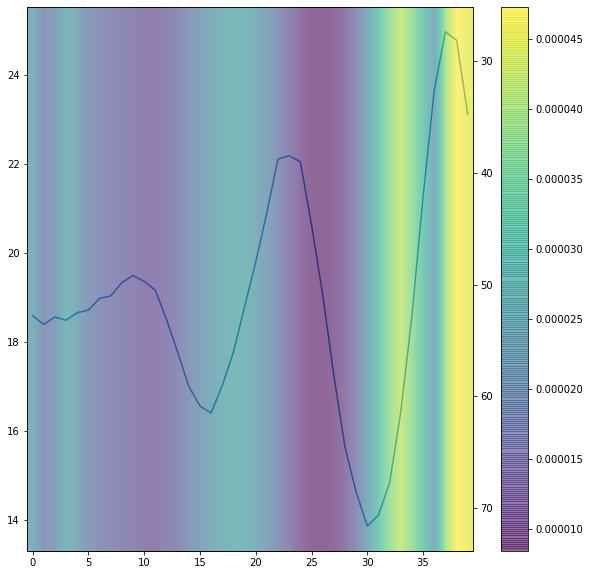

ITN2
Importance: 6.661586%


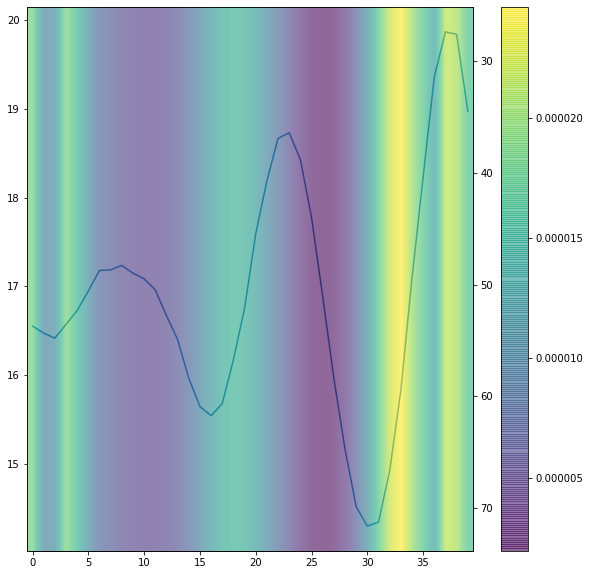

ITN3
Importance: 5.088956%


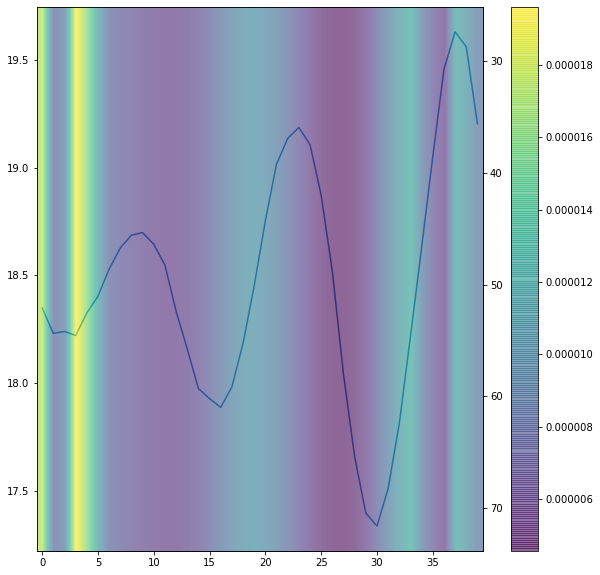

ITN4
Importance: 4.247313%


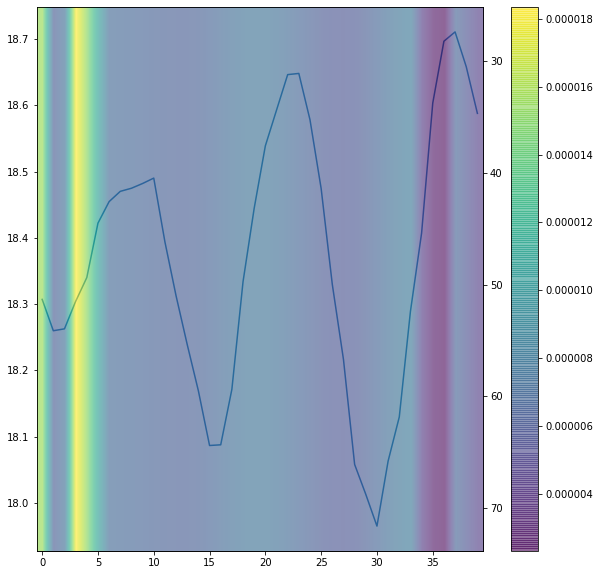

ITN5
Importance: 2.0152833%


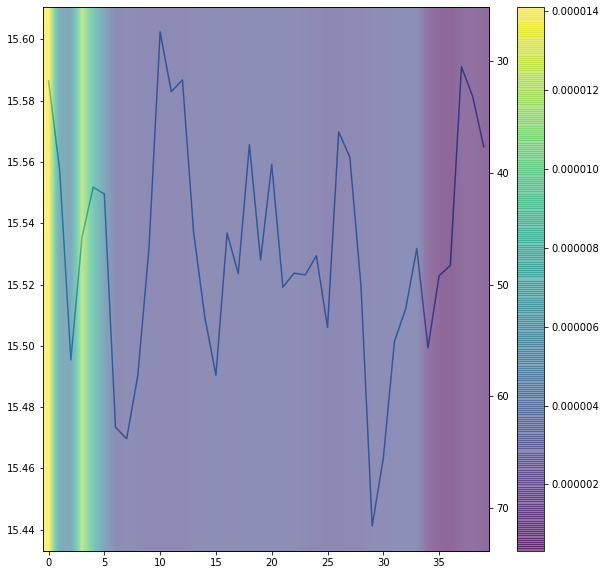

rawLFP
Importance: 10.853676%


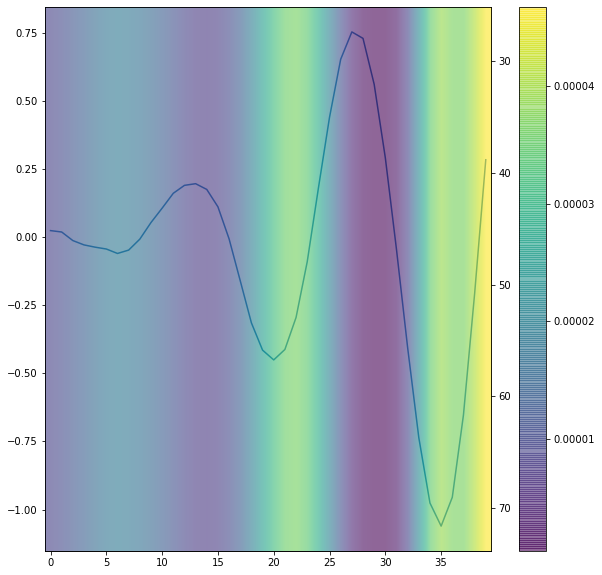

avgPNA
Importance: 3.190193%


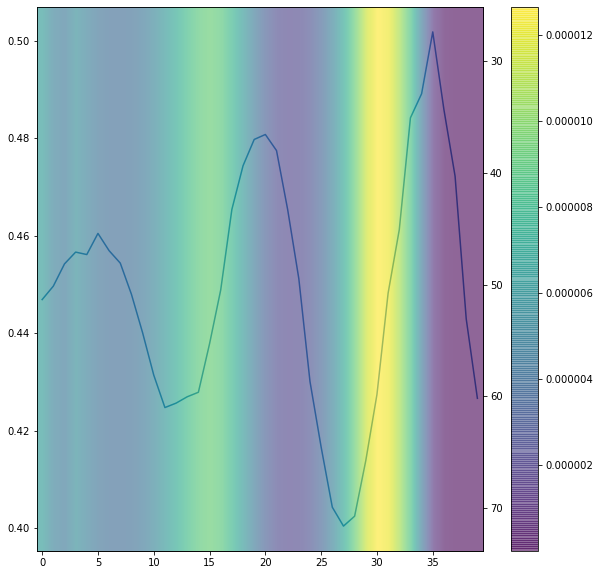

avgPNC
Importance: 6.014743%


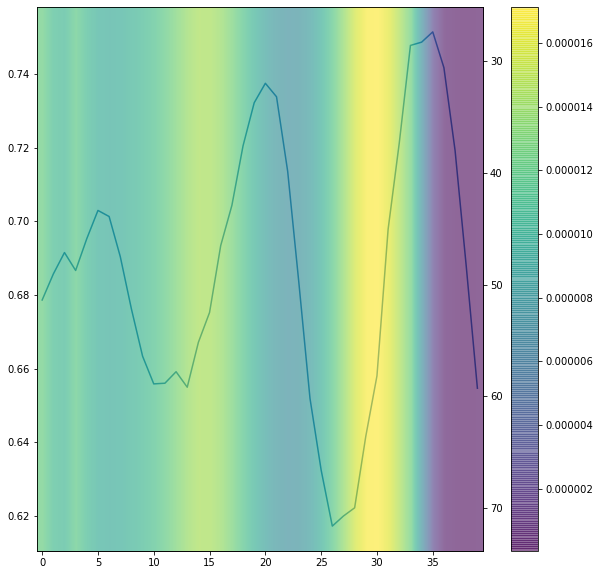

avgITN
Importance: 5.239726%


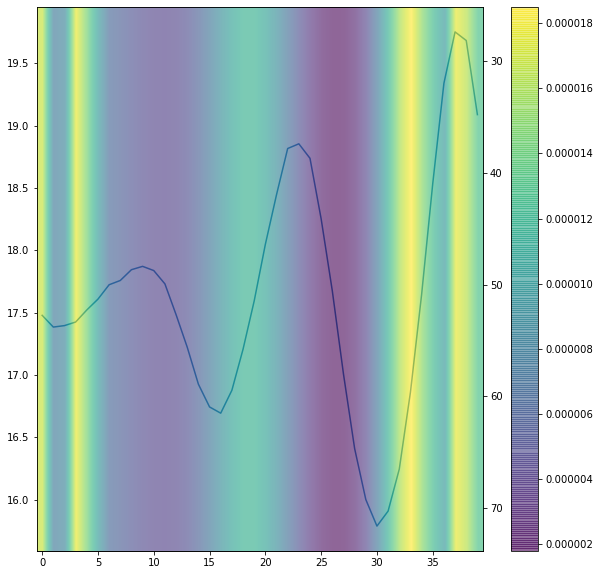

In [85]:
for i in range(19):
    print(var_names[i])
    print("Importance: ", t_imp[i], "%", sep = '')
    plot_avg_var_map(i, data.valid_ds, t_gs, 0)

In [105]:
item = data.valid_ds[4755]; item[1]

Category 1

In [106]:
get_pred(item) == 1

True

In [107]:
g = get_grad_cam(data, item, 5, m)

In [108]:
g.shape

torch.Size([19, 40])

In [109]:
g = relu(g)

In [112]:
g = percentize(np.array(g))

In [113]:
xs = np.array(item[0].data[0])

In [114]:
xs.shape

(40, 19)

In [115]:
xs = np.transpose(xs)

In [116]:
xs = percentize(xs)

Data in heatmap form (This is a sample that had a peak/trough above)

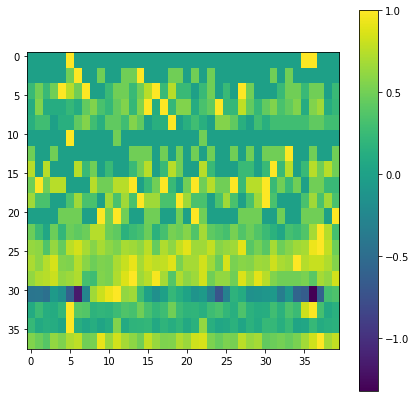

In [121]:
plt.figure(figsize = (7, 7))
plt.imshow(np.repeat(xs, 2, 0))
plt.colorbar()
plt.show()

GradCam results of the same sample as above

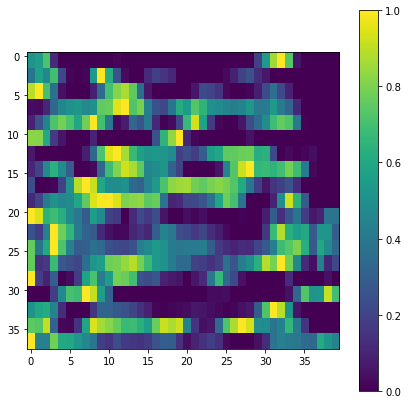

In [122]:
plt.figure(figsize = (7, 7))
plt.imshow(np.repeat(g, 2, 0))
plt.colorbar()
plt.show()